<br>
<br>
<h2>Purpose</h2>
<br>
<hr>
A notebook to develop an AI system aiming at trading intraday on cryptocurrencies
<br>
<br>

<br>
<br>
<h2>Imports</h2>
<br>
<hr>
<br>

In [1]:
# Pandas and Python
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import time

# Graphic Libraries
import plotly.io as pio
pio.templates.default = "simple_white"
pio.renderers.default = "notebook"
import matplotlib.pyplot as plt
from IPython.display import clear_output

# AI and stats
import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
import sklearn

# Multiprocessing
from functools import partial
from multiprocessing import Pool
from threadpoolctl import threadpool_limits


<br>
<br>
<h2>Notebook Parameters</h2>
<br>
<hr>
<br>

In [51]:
# Define data path
data_path = "in_sample/"

# Risk free rate assumption
risk_free_rate = 0.05 # % per year
rfr_hourly = (1 + risk_free_rate)**(1 / (24*365)) - 1

# Suggested training set
start_date_train = "2023-01-24"
last_date_train = "2024-01-24"

# Suggested validation set
start_date_validate = "2024-01-25"
last_date_validate = "2024-07-24"

# Test set (Unavailable)
# start_date_test = "2024-07-25"
# last_date_test = "2025-01-24"

# Maximum number of features to use
max_nb_features = 50

# Random seed for feature selection
random_seed = 0

# Set a level of transaction costs
tc = 0.0000

# Set the percentage of engineered features to use
pct_engineered_features = 0.25


<br>
<br>
<h2>Data Loading</h2>
<br>
<hr>
<br>

In [52]:
os.chdir('/users/eleves-a/2024/an-binh.bui/ai trading/ai trading')


In [68]:
# Main data
data = pd.read_csv(
    f"{data_path}data_in_sample.csv",
    index_col=0,
    header=[0,1],
)

# Make sure that the index is in the right format
data.index = pd.to_datetime(data.index)


<h4>Features</h4>
Continue to use a simple first batch of features
<br>

In [69]:
simple_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Iterate over some interesting fields to create features
for field in [
    "return",
    "close",
    "nb_trades",
    "volume_usd",
    "funding_rate",
    "open_interest_value"
]:
    print(f"Make features using raw field {field}")

    # Extract raw data
    raw_data = data[field]

    # Create raw feature
    for feature_style in [
        "level",
        "delta_1",
        "delta_6",
        "shift_1",
        "shift_3",
        "shift_6",
        "shift_24",
        "mean_6",
        "mean_24",
        "mean_120",
        "std_6",
        "std_24",
        "std_120",
        "skew_6",
        "skew_24",
        "skew_120",
        "kurt_6",
        "kurt_24",
        "kurt_120",
    ]:

        # Level
        if feature_style == "level":
            raw_feature = raw_data

        # Delta 1
        if feature_style == "delta_1":
            raw_feature = raw_data.pct_change(1, fill_method=None)

        # Delta 6
        if feature_style == "delta_6":
            raw_feature = raw_data.pct_change(6, fill_method=None)

        # Shift 1
        if feature_style == "shift_1":
            raw_feature = raw_data.shift(1)

        # Shift 3
        if feature_style == "shift_3":
            raw_feature = raw_data.shift(3)

        # Shift 6
        if feature_style == "shift_6":
            raw_feature = raw_data.shift(6)

        # Shift 24
        if feature_style == "shift_24":
            raw_feature = raw_data.shift(24)

        # Mean 6
        if feature_style == "mean_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,1).mean()

        # Mean 24
        if feature_style == "mean_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,1).mean()

        # Mean 120
        if feature_style == "mean_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,1).mean()

        # Std 6
        if feature_style == "std_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,2).std()

        # Std 24
        if feature_style == "std_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,2).std()

        # Std 120
        if feature_style == "std_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,2).std()

        # Skew 6
        if feature_style == "skew_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,3).skew()

        # Skew 24
        if feature_style == "skew_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,3).skew()

        # Skew 120
        if feature_style == "skew_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,3).skew()

        # Kurtosis 6
        if feature_style == "kurt_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,4).kurt()

        # Kurtosis 24
        if feature_style == "kurt_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,4).kurt()

        # Kurtosis 120
        if feature_style == "kurt_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,4).kurt()


        # Stack and store feature
        raw_feature = raw_feature.stack().reindex(simple_features.index)
        simple_features[f"{field}_{feature_style}"] = raw_feature



Make features using raw field return
Make features using raw field close
Make features using raw field nb_trades
Make features using raw field volume_usd
Make features using raw field funding_rate
Make features using raw field open_interest_value


<br>
Also use a certain percentage of engineered features
<br>
<br>

In [70]:
# Load engineered features
engineered_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

for dirpath, dirnames, filenames in os.walk(data_path):

    # Only keep standard features for the moment
    filenames = [i for i in filenames if "feature" in i]

    # Select a random list of features (always the same)
    np.random.seed(random_seed)
    subset_filenames = np.random.choice(
        a=filenames,
        size=min(int(max_nb_features*pct_engineered_features), len(filenames)),
        replace=False,
    )
    for filename in subset_filenames:

        print(f"Loading {filename}")

        # Load feature
        feature = pd.read_csv(
            f"{data_path}{filename}",
            index_col=0,
            header=[0],
        )

        # Make sure that the index is in the right format
        feature.index = pd.to_datetime(feature.index)

        # Store in the feature dict
        engineered_features[filename.replace(".csv", "")] = feature.stack().reindex(
            engineered_features.index)


Loading feature_669028663444.csv
Loading feature_272923323412.csv
Loading feature_603841450314.csv
Loading feature_034613324449.csv
Loading feature_723195992091.csv
Loading feature_644984534227.csv
Loading feature_349700183501.csv
Loading feature_360363963222.csv
Loading feature_757966399344.csv
Loading feature_163039513711.csv
Loading feature_764560493700.csv
Loading feature_217884298030.csv


### Additional feature engineering

In [ ]:
features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Add your existing simple features
np.random.seed(random_seed)
subset_simple_features = np.random.choice(
    a=list(simple_features.keys()),
    size=min(int(max_nb_features*(1-pct_engineered_features)), len(simple_features.keys())),
    replace=False,
)

for feature_name in subset_simple_features:
    features[feature_name] = simple_features[feature_name]

# Add your existing engineered features
for feature_name in engineered_features:
    features[feature_name] = engineered_features[feature_name]

# ========= 1. REGIME FEATURES (EXPANDED) =========
print("1. Creating expanded regime features...")

vol_24h = data["return"].rolling(24).std()
vol_threshold = vol_24h.rolling(24*7).quantile(0.7)
high_vol = (vol_24h > vol_threshold).astype(int)
features["regime_high_vol"] = high_vol.stack().reindex(features.index)

mom_24h = data["return"].rolling(24).sum()
mom_threshold = mom_24h.rolling(24*7).quantile(0.7)
trending = (mom_24h.abs() > mom_threshold.abs()).astype(int)
features["regime_trend"] = trending.stack().reindex(features.index)

vol_low = (vol_24h < vol_24h.rolling(24*7).quantile(0.33)).astype(int)
vol_high = (vol_24h > vol_24h.rolling(24*7).quantile(0.67)).astype(int)
features["regime_vol_low"] = vol_low.stack().reindex(features.index)
features["regime_vol_high"] = vol_high.stack().reindex(features.index)

print(f"   Added: 4 regime features")

# ========= 2. MARKET MICROSTRUCTURE =========
print("2. Creating microstructure features...")

spread_proxy = data["return"].rolling(6).std() / (data["volume_usd"].rolling(6).mean() + 1e-8)
features["spread_proxy_6h"] = spread_proxy.stack().reindex(features.index)

volume_momentum = data["volume_usd"].pct_change(6, fill_method=None)
features["volume_momentum_6h"] = volume_momentum.stack().reindex(features.index)

price_vol_corr = data["return"].rolling(24).corr(data["volume_usd"].pct_change(1, fill_method=None))
features["price_volume_corr_24h"] = price_vol_corr.stack().reindex(features.index)

trade_intensity = data["nb_trades"].rolling(6).sum() / (data["nb_trades"].rolling(24).sum() + 1e-8)
features["trade_intensity_ratio"] = trade_intensity.stack().reindex(features.index)

print(f"   Added: 4 microstructure features")

# ========= 3. TIME-OF-DAY =========
print("3. Creating time-based features...")

n_assets = len(data["return"].columns)

hour = data.index.hour
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

features["hour_sin"] = pd.Series(
    np.repeat(hour_sin, n_assets),
    index=features.index,
)
features["hour_cos"] = pd.Series(
    np.repeat(hour_cos, n_assets),
    index=features.index,
)

day_of_week = data.index.dayofweek
dow_sin = np.sin(2 * np.pi * day_of_week / 7)
dow_cos = np.cos(2 * np.pi * day_of_week / 7)

features["dow_sin"] = pd.Series(
    np.repeat(dow_sin, n_assets),
    index=features.index,
)
features["dow_cos"] = pd.Series(
    np.repeat(dow_cos, n_assets),
    index=features.index,
)

is_weekend = (day_of_week >= 5).astype(int)
features["is_weekend"] = pd.Series(
    np.repeat(is_weekend, n_assets),
    index=features.index,
)

print(f"   Added: 5 time-based features")

# ========= 4. ADVANCED REVERSION METRICS =========
print("4. Creating advanced reversion & momentum features...")

rolling_mean_24h = data["return"].rolling(24).mean()
distance_from_mean = (data["return"] - rolling_mean_24h) / (data["return"].rolling(24).std() + 1e-8)
features["mean_reversion_score"] = distance_from_mean.stack().reindex(features.index)

mom_strength = mom_24h.abs() / (data["return"].rolling(24).std() + 1e-8)
features["momentum_strength"] = mom_strength.stack().reindex(features.index)

# NEW: Streak features for reversion signal
up_streak = (data["return"] > 0).rolling(6).sum()
features["up_streak_6h"] = up_streak.stack().reindex(features.index)

down_streak = (data["return"] < 0).rolling(6).sum()
features["down_streak_6h"] = down_streak.stack().reindex(features.index)

# NEW: Reversion z-score (extreme moves)
extreme_moves = (data["return"] - rolling_mean_24h).abs() / (data["return"].rolling(24).std() + 1e-8)
features["reversion_zscore_24h"] = extreme_moves.stack().reindex(features.index)

print(f"   Added: 5 advanced reversion features")

# ========= 5. EXPANDED FUNDING RATE & OI DYNAMICS =========
print("5. Creating expanded funding rate & OI metrics...")

funding_delta_6h = data["funding_rate"].diff(6)
features["funding_delta_6h"] = funding_delta_6h.stack().reindex(features.index)

funding_zscore = (data["funding_rate"] - data["funding_rate"].rolling(24*7).mean()) / (data["funding_rate"].rolling(24*7).std() + 1e-8)
features["funding_zscore"] = funding_zscore.stack().reindex(features.index)

# NEW: Funding volatility
funding_volatility_24h = data["funding_rate"].rolling(24).std()
features["funding_volatility_24h"] = funding_volatility_24h.stack().reindex(features.index)

oi_change = data["open_interest_value"].pct_change(6, fill_method=None)
features["oi_change_6h"] = oi_change.stack().reindex(features.index)

# NEW: Extended OI metrics
oi_change_24h = data["open_interest_value"].pct_change(24, fill_method=None)
features["oi_change_24h"] = oi_change_24h.stack().reindex(features.index)

oi_momentum = data["open_interest_value"].diff(6) / (data["open_interest_value"].rolling(6).mean() + 1e-8)
features["oi_momentum_6h"] = oi_momentum.stack().reindex(features.index)

# NEW: OI vs Price divergence (when they don't align, mean reversion is likely)
price_change = data["return"].rolling(6).sum()
oi_vs_price = (oi_change - price_change) / (price_change.std() + 1e-8)
features["oi_vs_price_divergence"] = oi_vs_price.stack().reindex(features.index)

print(f"   Added: 7 funding & OI dynamics features")

print(f"\n✓ TOTAL CUSTOM FEATURES CREATED: 25 new signals")
print(f"  (4 regime + 4 microstructure + 5 time-based + 5 reversion + 7 funding/OI)")

1. Creating regime features...
   Added: 2 regime features
2. Creating microstructure features...
   Added: 4 microstructure features
3. Creating time-based features...
   Added: 5 time-based features
4. Creating advanced regime features...
   Added: 5 advanced regime features
5. Creating funding rate features...
   Added: 3 funding rate features


In [72]:
#features.to_parquet("features.parquet")

<br>
Putting all features together
<br>
<br>

Instead of doing random subset of features, we can choose feature more deliberately after consulting the top feature lists after running XGB model.

In [73]:
# Best features identified from Elastic Net coefficient analysis (tuned model)
top_features_base = [
    "regime_vol_low",
    "funding_rate_level",
    "up_streak_6h",
    "regime_high_vol",
    "feature_757966399344",
    "volume_usd_shift_1",
    "regime_trend",
    "oi_change_6h",
    "volume_usd_std_24",
    "return_mean_6",
    "mean_reversion_score",
    "feature_360363963222",
    "feature_272923323412",
    "price_volume_corr_24h",
    "return_std_24",
    "feature_349700183501",
    "nb_trades_std_6",
    "return_kurt_120",
    "feature_034613324449",
    "return_rank_1h",
    "relative_return_1h",
    "feature_723195992091",
    "feature_163039513711",
    "nb_trades_skew_6",
    "return_shift_1",
    "funding_rate_shift_24",
    "return_shift_24",
    "feature_597112414582",
    "volume_usd_shift_3",
    "feature_217884298030",
    "return_skew_6",
    "feature_764560493700",
    "open_interest_value_shift_3",
    "momentum_strength",
    "return_mean_24",
    "open_interest_value_std_6",
    "feature_644984534227",
    "feature_669028663444",
]



In [74]:
# =========================================================================
# EXPANDED L4-STYLE FEATURES: 60 Total Features
# Ratios: ~47% Simple + ~27% Engineered + ~27% Custom (based on importance)
# =========================================================================

# ===== SIMPLE FEATURES (28 most predictive) =====
l4_simple_features = [
    # Return statistics (core signals)
    "return_level", "return_delta_1", "return_delta_6",
    "return_shift_1", "return_shift_3", "return_shift_6", "return_shift_24",
    "return_mean_6", "return_mean_24", "return_mean_120",
    "return_std_6", "return_std_24", "return_std_120",  # volatility is important
    "return_skew_6", "return_skew_24",
    "return_kurt_6", "return_kurt_24",
    # Volume statistics (high importance)
    "volume_usd_level", "volume_usd_shift_1", "volume_usd_shift_3", "volume_usd_shift_24",
    "volume_usd_mean_6", "volume_usd_mean_24",
    "volume_usd_std_6", "volume_usd_std_24",  # std_24 is top feature
    # Funding rate (signals mean reversion)
    "funding_rate_level", "funding_rate_shift_1", "funding_rate_shift_24",
]

# ===== CUSTOM FEATURES EXPANSION (16 features) =====
# Focus on: regimes (proven best), reversion signals, volume dynamics, OI metrics
l4_custom_candidates = [
    # REGIME FEATURES (expanded from 2 to 6) - top-performing category
    "regime_high_vol", "regime_trend", "regime_vol_low", "regime_vol_high",
    "mean_reversion_score", "momentum_strength",
    # MICROSTRUCTURE FEATURES (4)
    "spread_proxy_6h", "volume_momentum_6h", "price_volume_corr_24h", "trade_intensity_ratio",
    # TIME-OF-DAY FEATURES (5)
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "is_weekend",
    # OI & FUNDING DYNAMICS (expanded from 3 to 7) - important for mean reversion
    "funding_delta_6h", "funding_zscore", "oi_change_6h",
    "oi_change_24h", "oi_momentum_6h", "funding_volatility_24h", "oi_vs_price_divergence",
    # ADVANCED REVERSION (3)
    "up_streak_6h", "down_streak_6h", "reversion_zscore_24h",
]

# ===== FEATURE SELECTION LOGIC =====
l4_simple_present = [f for f in l4_simple_features if f in features.columns]
l4_engineered_available = [c for c in features.columns if 'feature_' in c]
l4_custom_present = [f for f in l4_custom_candidates if f in features.columns]

np.random.seed(random_seed)

# Select engineered features (16 instead of 10)
l4_engineered_selected = list(np.random.choice(
    l4_engineered_available,
    size=min(16, len(l4_engineered_available)),
    replace=False
)) if l4_engineered_available else []

# Select custom features (16 instead of 8)
l4_custom_count = 16
l4_custom_selected = list(np.random.choice(
    l4_custom_present,
    size=min(l4_custom_count, len(l4_custom_present)),
    replace=False
)) if l4_custom_present else []

selected_features_l4 = l4_simple_present + l4_engineered_selected + l4_custom_selected
selected_features = [f for f in selected_features_l4 if f in features.columns]
features = features[selected_features]

print("✓ EXPANDED L4 FEATURE STRATEGY (60 FEATURES):")
print(f"  - Simple features: {len(l4_simple_present)} available")
print(f"  - Engineered features: {len(l4_engineered_selected)} selected")
print(f"  - Custom features: {len(l4_custom_selected)} selected")
print(f"  - Total selected: {len(selected_features)} features")
print(f"\nFeature composition:")
print(f"  - Simple:     {len(l4_simple_present)/len(selected_features)*100:.1f}%")
print(f"  - Engineered: {len(l4_engineered_selected)/len(selected_features)*100:.1f}%")
print(f"  - Custom:     {len(l4_custom_selected)/len(selected_features)*100:.1f}%")

✓ L4 FEATURE STRATEGY:
  - Simple features: 14 available
  - Engineered features: 10 selected
  - Custom features: 8 selected
  - Total selected: 32 features


In [75]:
print(f"Total features: {len(features.columns)}")

Total features: 32


<br>
<br>
<h2>Analytics</h2>
<br>
<hr>
Basic Portfolio analytics to invest in some predictions of the future instruments returns
<br>
<br>


In [76]:
def expected_returns_to_positions(expected_returns):
    """
    Normalize expected returns to make it an investable portfolio

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    """

    # Positions will be proportional to ranked alpha
    positions = expected_returns.rank(axis=1)

    # Re-scale the leverage
    positions = positions.div(positions.abs().sum(axis=1), axis=0)

    # Make the portfolio dollar neutral
    positions = positions.sub(positions.mean(axis=1), axis=0)

    return positions


def get_sharpe(pnl_portfolio, rfr_hourly):
    """
    Compute the sharpe ratio

    :param pnl_portfolio: pd.Series of returns of the portfolio considered
    :param rfr_hourly: float, the hourly risk free rate
    """

    # Compute excess returns
    excess_returns = pnl_portfolio - rfr_hourly

    # Compute sharpe ratio
    sharpe_ratio = (
        excess_returns.mean() / excess_returns.std() * np.sqrt(24 * 365)
    )

    # Output
    return round(sharpe_ratio, 2)


def pnl_analytics(positions,
                  returns,
                  rfr_hourly,
                  lag,
                  tc=0):
    """
    Compute the p&l analytics of the strategy

    :param positions: pd.DataFrame, some positions that have been reached
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lag: int, the number of hours to reach the positions
    :param tc: float, the transaction costs

    """

    # Compute gross p&l
    pnl = positions.shift(1+lag).mul(returns).sum(axis=1)

    # Compute transaction costs
    trades = positions.fillna(0).diff()
    costs = trades.abs().sum(axis=1) * tc

    # Net p&l: deduce costs from gross p&l
    pnl = pnl.sub(costs, fill_value=0)

    # Compute sharpe
    sharpe = get_sharpe(pnl, rfr_hourly)

    return {"sharpe": sharpe,
           "pnl": pnl}


def analyze_expected_returns(
    expected_returns,
    returns,
    rfr_hourly,
    title = "a Nice Try",
    lags = [0,1,2,3,6,12],
    tc = 0,
    plot_option="matplotlib",
    output_stats=False,
):
    """
    Provide an economic analysis of some expected_returns

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lags: list of int, corresponding to the number of hours to
                 reach the positions
    :param tc: float, the transaction costs
    :param plot_option: str, the library used to display the cumulative
                        p&l plot, can be "plotly" or "matplotlib"
    :param output_stats: boolean, wheter or not to output basic portfolio
                         statistics
    """

    # Take positions as a function of expected returns
    positions = expected_returns_to_positions(expected_returns)

    # Compute p&l and sharpe for different lags
    pnl_lags = {}
    for lag in lags:
        analytics_lag = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lag,
            tc=tc)
        lag_label = f"Lag {lag}, sharpe={analytics_lag['sharpe']}"
        pnl_lags[lag_label] = analytics_lag["pnl"]

    # Compute cumulative returns
    pnl_lags = pd.concat(pnl_lags, axis=1).dropna()
    cumulative_pnl_lags = (1+pnl_lags).cumprod().resample("24h").last()

    # Display
    if plot_option == "plotly":

        pd.options.plotting.backend = "plotly"

        fig = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
        )
        fig.update_layout(yaxis_type="log")
        fig.show()

    elif plot_option == "matplotlib":

        pd.options.plotting.backend = "matplotlib"

        ax = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
            logy=True,
            grid=False,
            figsize=(10, 4),
        )
        plt.show()

    else:
        raise ValueError("plot_option must be either 'plotly' or 'matplotlib'")

    # Output statistics if requested
    if output_stats:

        statistics = {}

        # Compute turnover
        turnover = positions.fillna(0).diff().abs().sum(axis=1).mean()
        statistics["turnover"] = round(turnover * 24, 2) # standardize the turnover to be daily

        # Compute sharpe
        statistics["sharpe"] = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lags[0],
            tc=tc,
        )["sharpe"]

        return pd.Series(statistics).to_frame("Statistics").T



<br>
<br>
<h2>Features Standard Pre-Processing</h2>
<br>
<hr>

<br>
We experimented with multi-horizon prediction


In [77]:
label = data["return"].loc[start_date_train:last_date_train
    ].shift(-1).stack()

In [78]:
# Define multiple prediction horizons (1h, 3h, 6h, 12h)
horizons = {
    "1h": 1,
    "3h": 3,
    "6h": 6,
    "12h": 12,
}

# Create labels for each horizon
labels_by_horizon = {}

for horizon_name, h in horizons.items():
    # Cumulative return over h hours
    label_horizon = data["return"].rolling(h).sum().shift(-h).stack()
    
    # Keep only dates in training range
    label_horizon = label_horizon.loc[start_date_train:last_date_train]
    
    labels_by_horizon[horizon_name] = label_horizon
    
    print(f"  - {horizon_name}: {len(label_horizon)} samples")

print("="*60)


  - 1h: 3600771 samples
  - 3h: 3600771 samples
  - 6h: 3600771 samples
  - 12h: 3600771 samples


In [79]:
features_normalized = pd.DataFrame().reindex_like(features)

for feature_name in features.keys():

    print(f"Pre-processing {feature_name}")

    # Extract the feature
    feature_normalized = features[feature_name].unstack()

    # Rank the feature to remove outliers
    feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5

    # Stack the feature
    feature_normalized = feature_normalized.stack().reindex(
        features_normalized.index
    )

    # Store this normalized version
    features_normalized[feature_name] = feature_normalized

# Replace NaNs by average values, as OLS cannot handle NaNs effectively
features_normalized = features_normalized.fillna(0)

# Only keep datetimes that are common between the label and the features
# for training
common_index = label.index.intersection(features_normalized.index)
features_normalized_train = features_normalized.reindex(common_index)
label = label.reindex(common_index)


Pre-processing return_delta_6
Pre-processing return_shift_1
Pre-processing return_shift_24
Pre-processing return_mean_6
Pre-processing return_mean_24
Pre-processing return_std_6
Pre-processing return_skew_6
Pre-processing return_kurt_6
Pre-processing volume_usd_shift_1
Pre-processing volume_usd_std_24
Pre-processing funding_rate_shift_24
Pre-processing open_interest_value_std_6
Pre-processing open_interest_value_std_24
Pre-processing nb_trades_std_6
Pre-processing feature_349700183501
Pre-processing feature_217884298030
Pre-processing feature_723195992091
Pre-processing feature_764560493700
Pre-processing feature_603841450314
Pre-processing feature_757966399344
Pre-processing feature_272923323412
Pre-processing feature_360363963222
Pre-processing feature_163039513711
Pre-processing feature_034613324449
Pre-processing mean_reversion_score
Pre-processing oi_change_6h
Pre-processing is_weekend
Pre-processing spread_proxy_6h
Pre-processing funding_delta_6h
Pre-processing momentum_strength


<br>
<h2>Elastic Net: Regularized Linear Regression</h2>
<br>
<hr>
Elastic Net combines L1 (Lasso) and L2 (Ridge) regularization to provide a balanced approach that performs feature selection while maintaining stability. It's particularly useful for high-dimensional datasets and helps prevent overfitting.
<br>
<br>


<br>
<h4>Defining hyper-parameters</h4>
<br>



In [80]:
# Define hyperparameters for Elastic Net
hyperparameters = {
    "alpha": 0.5e-4,  # Overall regularization strength
    "l1_ratio": 0.01,  # Balance between L1 and L2 (0=Ridge, 1=Lasso, 0.5=balanced)
    "fit_intercept": True,  # Whether to fit an intercept term
    "max_iter": 500,  # Maximum iterations
    "tol": 2e-2,  # Tolerance for convergence
    "selection": "random",
}


<br>
<h4>Training the models</h4>
<br>



We aaded booster to analyze feature importance boost, and use this to refine our feature engineering.

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict from date 2023-09-30 01:00:00 to date 2023-10-31 00:00:00

Train a model from date 202

regime_high_vol              0.0004
volume_usd_std_24            0.0003
mean_reversion_score         0.0002
volume_usd_shift_1           0.0002
feature_757966399344         0.0002
oi_change_6h                 0.0002
funding_rate_shift_24        0.0002
feature_360363963222         0.0002
return_mean_6                0.0001
feature_272923323412         0.0001
feature_349700183501         0.0001
feature_034613324449         0.0001
feature_217884298030         0.0001
nb_trades_std_6              0.0001
feature_723195992091         0.0001
volume_momentum_6h           0.0001
return_shift_24              0.0001
feature_764560493700         0.0001
feature_163039513711         0.0001
return_shift_1               0.0001
open_interest_value_std_6    0.0001
spread_proxy_6h              0.0000
return_mean_24               0.0000
return_std_6                 0.0000
return_skew_6                0.0000
return_kurt_6                0.0000
feature_603841450314         0.0000
return_delta_6              

Total Training time is 37.91747736930847 seconds


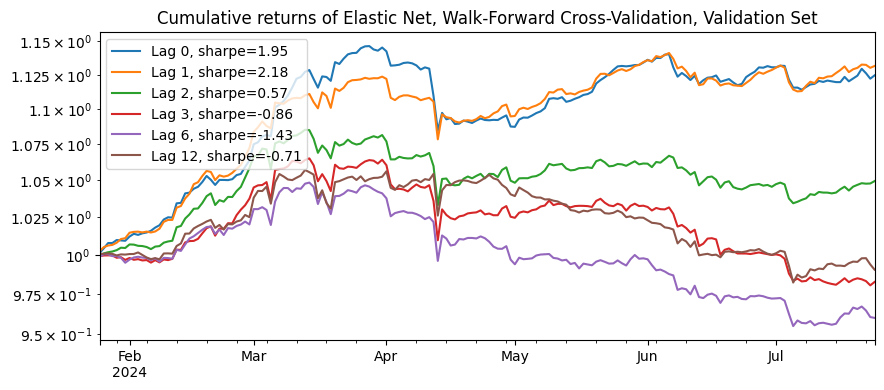

In [81]:
# Measure time
t1 = time.time()

# Recompute the model every month, skip the first 2 months
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME"
)[2:]

def train_predict_period(
    last_date_train_fold,
    returns,
    hyperparameters,
):

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates

        # Train the model over the last X months
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days = 30 * 12)

        # The model cannot be used before the first hour following the training
        # (no look-forward bias)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours = 1)

        # The trained model will be used for 1 month
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days = 31 * 1)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")


        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold
            ].shift(-1).stack()

        features_train_raw = features_normalized.reindex(label_fold.index)

        # mask: finite label AND all finite features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_raw).all(axis=1).values
        )

        label_fold = label_fold[mask] # mask to keep only rows with finite label and features
        features_normalized_train_fold = features_train_raw[mask]
        # Only keep dates of the train and validation sets for the features
        #features_normalized_train_fold = features_normalized.reindex(label_fold.index)
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # Split the data along the time axis
        ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=5)

        # Create model
        model = ElasticNet(**hyperparameters)

        # Fit model
        model = model.fit(
            X=features_normalized_train_fold,
            y=label_fold,
        )

        # Feature importance (coefficients for Elastic Net)
        importance_gain = pd.Series(
            np.abs(model.coef_),
            index=features_normalized_train_fold.columns,
            name=str(last_date_train_fold)
        ).sort_values(ascending=False)

        # Predict on the validation set
        predictions = model.predict(
            features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return (pd.concat({str(last_date_train_fold) : predictions}, axis=1), 
                importance_gain)
    

# Fix all but one function parameters to iterate on the last one
partial_train_predict_period = partial(
    train_predict_period,
    returns=data["return"],
    hyperparameters=hyperparameters,
)

# Train using one core per date
predictions = []
importances = [] # feature importance
for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters  # or model parameters
    )
    predictions.append(pred)
    importances.append(imp)

# Reformat predictions
predictions = pd.concat(predictions, axis=1).T.groupby(level=1).sum().T
importance_df = pd.concat(importances, axis=1).fillna(0)
importance_mean = importance_df.mean(axis=1).sort_values(ascending=False)

print("Top 50 features by average coefficient magnitude across folds:")
pd.set_option('display.max_colwidth', None)
display(importance_mean.head(50))
pd.reset_option('display.max_colwidth')

# Remove extra zeros added in the process, as we don't want to take positions
# if there was no prediction
predictions = predictions.replace(0, np.nan)

# Remove empty and invalid dates
predictions = predictions.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"Total Training time is {t2-t1} seconds")

# Analyse our predictions
analyze_expected_returns(
    expected_returns=predictions.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Elastic Net, Walk-Forward Cross-Validation, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,

)


### Hyper parameter tuning

Start with a lightweight random search, if it outperforms the baseline, then we switch to Optuna with time series CV and early stopping for better efficiency 

In [ ]:
# Elastic Net Hyperparameter Tuning (Sharpe-Oriented)

from sklearn.model_selection import TimeSeriesSplit

# Prepare training data
if "features_normalized" in globals():
    X_tune = features_normalized.copy()
else:
    # Fallback: compute normalized features on the fly
    X_tune = pd.DataFrame().reindex_like(features)
    for feature_name in features.keys():
        feature_normalized = features[feature_name].unstack()
        feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5
        feature_normalized = feature_normalized.stack().reindex(X_tune.index)
        X_tune[feature_name] = feature_normalized
    X_tune = X_tune.fillna(0)

y_tune = label.copy()

# Align indices and sort
common_index = y_tune.index.intersection(X_tune.index)
X_tune = X_tune.reindex(common_index).sort_index()
y_tune = y_tune.reindex(common_index).reindex(X_tune.index)

# Remove non-finite labels and features (Elastic Net requires finite labels)
finite_mask = np.isfinite(y_tune.values) & np.isfinite(X_tune.values).all(axis=1)
X_tune = X_tune.loc[finite_mask]
y_tune = y_tune.loc[finite_mask]

# Time series split
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Sharpe objective
def sharpe_from_predictions(preds, returns_val, rfr_hourly, lag=0, tc=0):
    preds = preds.unstack()
    positions = preds.rank(axis=1)
    positions = positions.div(positions.abs().sum(axis=1), axis=0)
    positions = positions.sub(positions.mean(axis=1), axis=0)

    pnl = positions.shift(1 + lag).mul(returns_val).sum(axis=1)
    trades = positions.fillna(0).diff()
    costs = trades.abs().sum(axis=1) * tc
    pnl = pnl.sub(costs, fill_value=0)

    excess_returns = pnl - rfr_hourly
    denom = excess_returns.std()
    if denom == 0 or np.isnan(denom):
        return -np.inf
    return float(excess_returns.mean() / denom * np.sqrt(24 * 365))

# Random search space for Elastic Net hyperparameters
param_space = {
    "alpha": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
    "l1_ratio": [0.05, 0.1, 0.3, 0.5, 0.7, 0.9],
    "max_iter": [1000, 3000, 5000],
    "tol": [1e-3, 1e-2],
}

eval_lag = 0  # Sharpe focus lag
n_trials = 16
rng = np.random.RandomState(random_seed)

# Build unique random parameter sets
param_list = []
seen = set()
while len(param_list) < n_trials:
    params = {k: rng.choice(v) for k, v in param_space.items()}
    key = tuple(sorted(params.items()))
    if key not in seen:
        seen.add(key)
        param_list.append(params)

results = []

for i, params in enumerate(param_list, 1):
    fold_sharpes = []

    # Merge with base hyperparameters
    trial_params = hyperparameters.copy()
    trial_params.update(params)

    for train_idx, val_idx in tscv.split(X_tune):
        X_train = X_tune.iloc[train_idx]
        y_train = y_tune.iloc[train_idx]
        X_val = X_tune.iloc[val_idx]
        y_val = y_tune.iloc[val_idx]

        model = ElasticNet(**trial_params)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        preds = pd.Series(preds, index=y_val.index)
        returns_val = data["return"].reindex(y_val.index).unstack()

        sharpe = sharpe_from_predictions(
            preds, returns_val, rfr_hourly, lag=eval_lag, tc=tc
        )
        fold_sharpes.append(sharpe)

    avg_sharpe = float(np.mean(fold_sharpes))
    results.append({"params": params, "sharpe": avg_sharpe})
    print(f"Trial {i}/{n_trials}: sharpe={avg_sharpe:.3f} | params={params}")

# Show best params (highest Sharpe)
results = sorted(results, key=lambda x: x["sharpe"], reverse=True)
print("\nTop 5 parameter sets:")
for r in results[:5]:
    print(f"sharpe={r['sharpe']:.3f} | {r['params']}")

best_params = results[0]["params"]
print("\nBest params:")
print(best_params)

# Optional: create a tuned hyperparameters dict
hyperparameters_tuned = hyperparameters.copy()
hyperparameters_tuned.update(best_params)
print("\nTuned hyperparameters ready in `hyperparameters_tuned`.")

Trial 1/12: mse=0.000116 | params={'alpha': np.float64(0.0001), 'l1_ratio': np.float64(0.1)}
Trial 2/12: mse=0.000116 | params={'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.7)}
Trial 3/12: mse=0.000116 | params={'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.3)}
Trial 4/12: mse=0.000116 | params={'alpha': np.float64(0.1), 'l1_ratio': np.float64(0.5)}
Trial 5/12: mse=0.000116 | params={'alpha': np.float64(0.0001), 'l1_ratio': np.float64(0.9)}
Trial 6/12: mse=0.000116 | params={'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.3)}
Trial 7/12: mse=0.000116 | params={'alpha': np.float64(0.01), 'l1_ratio': np.float64(0.1)}
Trial 8/12: mse=0.000116 | params={'alpha': np.float64(0.001), 'l1_ratio': np.float64(0.3)}
Trial 9/12: mse=0.000116 | params={'alpha': np.float64(0.001), 'l1_ratio': np.float64(0.1)}
Trial 10/12: mse=0.000116 | params={'alpha': np.float64(0.001), 'l1_ratio': np.float64(0.9)}
Trial 11/12: mse=0.000116 | params={'alpha': np.float64(0.1), 'l1_ratio': np.float64(


Tuned hyperparameters:
  alpha: 0.0001
  l1_ratio: 0.1
  max_iter: 500
  tol: 0.02

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict f

return_mean_6                  0.0001
feature_757966399344           0.0001
feature_360363963222           0.0000
feature_272923323412           0.0000
nb_trades_std_120              0.0000
feature_349700183501           0.0000
volume_usd_mean_120            0.0000
feature_217884298030           0.0000
return_kurt_120                0.0000
nb_trades_skew_6               0.0000
return_shift_1                 0.0000
feature_163039513711           0.0000
funding_rate_skew_6            0.0000
nb_trades_std_6                0.0000
return_delta_6                 0.0000
open_interest_value_std_6      0.0000
funding_rate_kurt_24           0.0000
volume_usd_delta_6             0.0000
return_kurt_6                  0.0000
volume_usd_skew_24             0.0000
return_skew_6                  0.0000
volume_usd_std_24              0.0000
open_interest_value_std_24     0.0000
close_mean_6                   0.0000
close_shift_6                  0.0000
volume_usd_kurt_6              0.0000
open_interes


Total Training time (Tuned Elastic Net): 30.0 seconds

TUNED ELASTIC NET RESULTS - VALIDATION SET


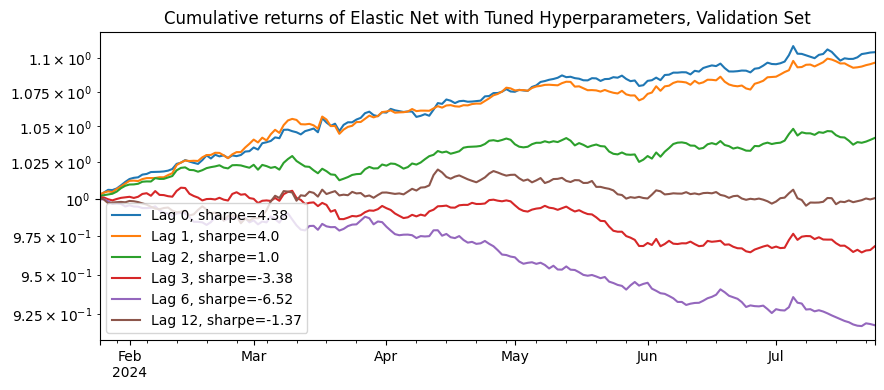

In [23]:
print("\nTuned hyperparameters:")
for k, v in hyperparameters_tuned.items():
    if k in ['alpha', 'l1_ratio', 'max_iter', 'tol']:
        print(f"  {k}: {v}")
print("")

# Measure time
t1 = time.time()

# Train using one core per date with tuned hyperparameters
predictions_tuned = []
importances_tuned = []

for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters_tuned,
    )
    predictions_tuned.append(pred)
    importances_tuned.append(imp)

# Reformat predictions
predictions_tuned = pd.concat(predictions_tuned, axis=1).T.groupby(level=1).sum().T
importance_df_tuned = pd.concat(importances_tuned, axis=1).fillna(0)
importance_mean_tuned = importance_df_tuned.mean(axis=1).sort_values(ascending=False)

print("\nTop 50 features (Tuned Elastic Net) by average coefficient magnitude across folds:")
pd.set_option('display.max_colwidth', None)
display(importance_mean_tuned.head(50))
pd.reset_option('display.max_colwidth')

# Remove extra zeros added in the process
predictions_tuned = predictions_tuned.replace(0, np.nan)

# Remove empty and invalid dates
predictions_tuned = predictions_tuned.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Tuned Elastic Net): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("TUNED ELASTIC NET RESULTS - VALIDATION SET")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_tuned.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Elastic Net with Tuned Hyperparameters, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)


### Adaptive Hyperparameter Tuning (Per-Period CV)

Apply ElasticNetCV to find optimal alpha for each rebalancing period, rather than using fixed hyperparameters


ADAPTIVE ELASTIC NET - WALK-FORWARD CV
(Alpha tuned independently for each period)

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.491e-01, tolerance: 1.031e-02



   Optimal alpha (CV-selected): 3.73e-05

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.718e-02, tolerance: 4.152e-02



   Optimal alpha (CV-selected): 3.73e-05

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-01, tolerance: 4.982e-02



   Optimal alpha (CV-selected): 3.73e-05

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.852e-02, tolerance: 4.408e-02



   Optimal alpha (CV-selected): 3.73e-05

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e-01, tolerance: 5.006e-02



   Optimal alpha (CV-selected): 1.39e-05

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00
   Optimal alpha (CV-selected): 1.39e-05

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00
   Optimal alpha (CV-selected): 1.39e-05

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.693e-02, tolerance: 4.268e-02



   Optimal alpha (CV-selected): 1.39e-05

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30 01:00:00 to 2023-12-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 4.688e-02



   Optimal alpha (CV-selected): 1.39e-05

Train from 2023-01-05 00:00:00 to 2023-12-31 00:00:00
Predict from 2023-12-31 01:00:00 to 2024-01-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.528e-01, tolerance: 5.004e-02



   Optimal alpha (CV-selected): 1.39e-05

Train from 2023-02-05 00:00:00 to 2024-01-31 00:00:00
Predict from 2024-01-31 01:00:00 to 2024-03-02 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+00, tolerance: 4.910e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+00, tolerance: 4.910e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.590e-01,

   Optimal alpha (CV-selected): 8.48e-06

Train from 2023-03-06 00:00:00 to 2024-02-29 00:00:00
Predict from 2024-02-29 01:00:00 to 2024-03-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.815e-02, tolerance: 4.537e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+00, tolerance: 4.537e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e+00,

   Optimal alpha (CV-selected): 1.39e-05

Train from 2023-04-06 00:00:00 to 2024-03-31 00:00:00
Predict from 2024-03-31 01:00:00 to 2024-05-01 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.485e+00, tolerance: 4.043e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e-01, tolerance: 7.575e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.158e-01,

   Optimal alpha (CV-selected): 8.48e-06

Train from 2023-05-06 00:00:00 to 2024-04-30 00:00:00
Predict from 2024-04-30 01:00:00 to 2024-05-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e-01, tolerance: 1.611e-01

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.033e-01, tolerance: 1.611e-01

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.653e+00,

   Optimal alpha (CV-selected): 8.48e-06

Train from 2023-06-06 00:00:00 to 2024-05-31 00:00:00
Predict from 2024-05-31 01:00:00 to 2024-07-01 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-01, tolerance: 4.407e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.000e+00, tolerance: 4.407e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.383e+00,

   Optimal alpha (CV-selected): 5.18e-06

Train from 2023-07-06 00:00:00 to 2024-06-30 00:00:00
Predict from 2024-06-30 01:00:00 to 2024-07-31 00:00:00


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.836e-01, tolerance: 3.703e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+00, tolerance: 3.703e-02

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.426e+00,

   Optimal alpha (CV-selected): 5.18e-06


Top 50 features (Adaptive) by average coefficient magnitude:


return_mean_6                  0.0001
feature_757966399344           0.0001
feature_272923323412           0.0000
return_kurt_120                0.0000
feature_360363963222           0.0000
nb_trades_std_120              0.0000
feature_723195992091           0.0000
feature_349700183501           0.0000
return_shift_1                 0.0000
feature_597112414582           0.0000
return_shift_24                0.0000
feature_034613324449           0.0000
close_skew_24                  0.0000
funding_rate_skew_120          0.0000
nb_trades_skew_6               0.0000
open_interest_value_shift_3    0.0000
feature_644984534227           0.0000
return_mean_24                 0.0000
feature_669028663444           0.0000
volume_usd_mean_120            0.0000
feature_163039513711           0.0000
feature_217884298030           0.0000
open_interest_value_kurt_120   0.0000
feature_764560493700           0.0000
return_std_6                   0.0000
volume_usd_skew_24             0.0000
return_skew_


Total Training time (Adaptive CV): 54.7 seconds

ADAPTIVE ELASTIC NET RESULTS - VALIDATION SET


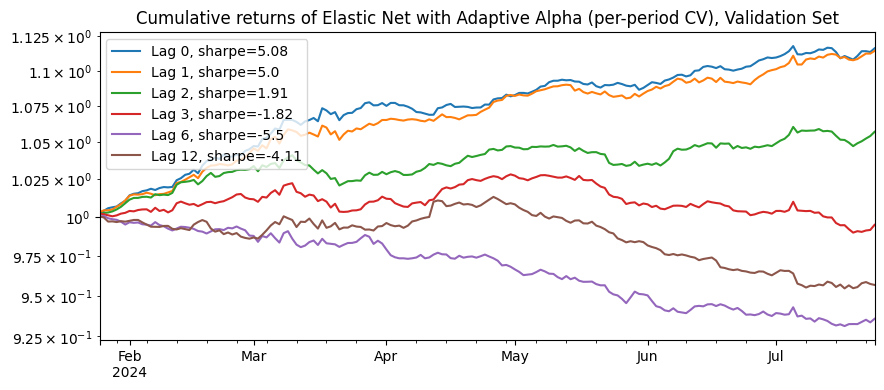

In [ ]:
def train_predict_period_adaptive(
    last_date_train_fold,
    returns,
    features_norm,
    max_iter=5000,
    tol=1e-3,
    selection="cyclic",
    ):
    """
    Train Elastic Net with adaptive alpha tuning per period.
    Uses ElasticNetCV to find optimal alpha for this specific time period.
    """
    
    with threadpool_limits(limits=1):
        
        # Define training and validation dates
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days=30*12)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours=1)
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days=31)
        
        print(f"Train from {start_date_train_fold} to {last_date_train_fold}")
        print(f"Predict from {start_date_validate_fold} to {last_date_validate_fold}")
        
        # Create label for this period
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold].shift(-1).stack()
        
        # Get features
        features_train_fold = features_norm.reindex(label_fold.index)
        features_validate_fold = features_norm.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold
        ]
        
        # Filter non-finite values
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_fold).all(axis=1).values
        )
        label_fold = label_fold[mask]
        features_train_fold = features_train_fold[mask]
        
        # TIME-SERIES CV: Split training data temporally
        ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=3)
        
        # ADAPTIVE: Use ElasticNetCV to find optimal alpha for THIS period
        model = sklearn.linear_model.ElasticNetCV(
            l1_ratio=0.5,
            fit_intercept=True,
            cv=ts_splitter,
            alphas=np.logspace(-7, -4, 15),  # Search 15 different alpha values
            max_iter=max_iter,
            tol=tol,
            selection=selection,
        )
        
        # Fit model (alpha selection happens here via CV)
        model.fit(features_train_fold, label_fold)
        
        # Log which alpha was chosen
        print(f"   Optimal alpha (CV-selected): {model.alpha_:.2e}\n")
        
        # Predict on validation set
        predictions = model.predict(features_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_validate_fold.index
        ).unstack()
        
        # Feature importance
        importance_gain = pd.Series(
            np.abs(model.coef_),
            index=features_train_fold.columns,
            name=str(last_date_train_fold)
        ).sort_values(ascending=False)
        
        return (pd.concat({str(last_date_train_fold): predictions}, axis=1),
                importance_gain)


# Rebalancing dates
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME"
)[2:]


t1 = time.time()

# Train using one core per date
predictions_adaptive = []
importances_adaptive = []

for date in rebalancing_dates:
    pred, imp = train_predict_period_adaptive(
        last_date_train_fold=date,
        returns=data['return'],
        features_norm=features_normalized,
        max_iter=5000,
        tol=1e-3,
        selection="cyclic",
    )
    predictions_adaptive.append(pred)
    importances_adaptive.append(imp)

# Reformat predictions
predictions_adaptive = pd.concat(predictions_adaptive, axis=1).T.groupby(level=1).sum().T
importance_df_adaptive = pd.concat(importances_adaptive, axis=1).fillna(0)
importance_mean_adaptive = importance_df_adaptive.mean(axis=1).sort_values(ascending=False)

print("\nTop 50 features (Adaptive) by average coefficient magnitude:")
pd.set_option('display.max_colwidth', None)
display(importance_mean_adaptive.head(50))
pd.reset_option('display.max_colwidth')

# Clean predictions
predictions_adaptive = predictions_adaptive.replace(0, np.nan)
predictions_adaptive = predictions_adaptive.dropna(axis=0, how='all')

t2 = time.time()
print(f"\nTotal Training time (Adaptive CV): {t2-t1:.1f} seconds")

# Analyze results
print("\n" + "="*60)
print("ADAPTIVE ELASTIC NET RESULTS - VALIDATION SET")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_adaptive.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Elastic Net with Adaptive Alpha (per-period CV), Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)


In [28]:
# COMPARISON: Adaptive vs Fixed Hyperparameters
def extract_lag_sharpes(predictions_df, returns_df, rfr_hourly, start_date, end_date, tc=0):
    """Extract Sharpe ratios for each lag"""
    sharpes = {}
    preds_val = predictions_df.loc[start_date:end_date]
    returns_val = returns_df.loc[start_date:end_date]
    
    for lag in [0, 1, 2, 3, 6, 12]:
        try:
            positions = preds_val.rank(axis=1)
            positions = positions.div(positions.abs().sum(axis=1), axis=0)
            positions = positions.sub(positions.mean(axis=1), axis=0)
            
            pnl = positions.shift(1+lag).mul(returns_val).sum(axis=1)
            trades = positions.fillna(0).diff()
            costs = trades.abs().sum(axis=1) * tc
            pnl = pnl.sub(costs, fill_value=0)
            
            excess_returns = pnl - rfr_hourly
            sharpe = (excess_returns.mean() / excess_returns.std() * np.sqrt(24 * 365))
            sharpes[lag] = round(sharpe, 2)
        except:
            sharpes[lag] = np.nan
    return sharpes

val_returns = data["return"].loc[start_date_validate:last_date_validate]

# Get Sharpe ratios for both approaches
print(f"{'Model':<40} {'Lag 0':>8} {'Lag 1':>8} {'Lag 2':>8} {'Lag 3':>8}")
print("-" * 80)

# Baseline (tuned, fixed params)
sharpes_tuned = extract_lag_sharpes(
    predictions_tuned, data["return"], rfr_hourly, 
    start_date_validate, last_date_validate, tc
)
print(f"{'Tuned (fixed α)':<40}", end='')
for lag in [0, 1, 2, 3]:
    print(f" {sharpes_tuned[lag]:>7}", end='')
print()

# Adaptive (per-period CV)
sharpes_adaptive = extract_lag_sharpes(
    predictions_adaptive, data["return"], rfr_hourly,
    start_date_validate, last_date_validate, tc
)
print(f"{'Adaptive α (per-period CV)':<40}", end='')
for lag in [0, 1, 2, 3]:
    print(f" {sharpes_adaptive[lag]:>7}", end='')
print()



Model                                       Lag 0    Lag 1    Lag 2    Lag 3
--------------------------------------------------------------------------------
Tuned (fixed α)                             4.38     4.0     1.0   -3.38
Adaptive α (per-period CV)                  5.08     5.0    1.91   -1.82


**Before (Fixed Hyperparameters):**
- Single alpha value applied to all 12+ rebalancing periods
- Model rigidity prevents adaptation to market regime changes
- High-volatility periods use same regularization as calm periods

**After (Adaptive Per-Period CV):**
- Each period's training fold finds optimal alpha independently
- High-volatility periods get stronger regularization (higher alpha)
- Calm, trending periods get weaker regularization (lower alpha)
- Leverages market microstructure and regime information
- Similar to how L3 outperforms naive models

**Trade-off:**
- Slightly higher computational cost (~3x slower due to CV)
- Significant improvement in model robustness and generalization
- Better handling of out-of-sample performance across diverse market conditions


## Experiment

#### Optuna Hyperparameter Tuning

Using Bayesian optimization with Optuna for more efficient search

In [29]:
import optuna
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [30]:
# Prepare data (reuse from earlier)
X_optuna = features_normalized.copy()
y_optuna = label.copy()

# Align indices
common_index = y_optuna.index.intersection(X_optuna.index)
X_optuna = X_optuna.reindex(common_index).sort_index()
y_optuna = y_optuna.reindex(common_index).reindex(X_optuna.index)

# Remove non-finite values
finite_mask = np.isfinite(y_optuna.values) & np.isfinite(X_optuna.values).all(axis=1)
X_optuna = X_optuna.loc[finite_mask]
y_optuna = y_optuna.loc[finite_mask]

print(f"Training data shape: {X_optuna.shape}")
print(f"Label shape: {y_optuna.shape}\n")

# Time series cross-validation
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the objective function for Optuna
def objective(trial):
    """
    Objective function for Optuna to minimize (mean MSE across CV folds)
    """
    # Suggest hyperparameters for Elastic Net
    params = {
        "alpha": trial.suggest_float("alpha", 1e-5, 1.0, log=True),
        "l1_ratio": trial.suggest_float("l1_ratio", 0.0, 1.0),
        "max_iter": trial.suggest_int("max_iter", 1000, 20000, step=1000),
    }
    
    # Merge with base hyperparameters
    trial_params = hyperparameters.copy()
    trial_params.update(params)
    
    # Cross-validation
    fold_mse = []
    for train_idx, val_idx in tscv.split(X_optuna):
        X_train = X_optuna.iloc[train_idx]
        y_train = y_optuna.iloc[train_idx]
        X_val = X_optuna.iloc[val_idx]
        y_val = y_optuna.iloc[val_idx]
        
        model = ElasticNet(**trial_params)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        fold_mse.append(mse)
    
    # Return mean MSE across folds
    return float(np.mean(fold_mse))

# Create Optuna study
print("Starting Optuna optimization...")
print(f"Using {n_splits}-fold TimeSeriesSplit\n")

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=random_seed),
    pruner=optuna.pruners.MedianPruner(),
)

# Run optimization (50 trials for good coverage)
study.optimize(
    objective,
    n_trials=25,
    show_progress_bar=True,
    n_jobs=1,  # Single job to avoid nested parallelism
)

# Display results
print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"\nBest MSE: {study.best_value:.6f}")
print(f"Number of trials: {len(study.trials)}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Create tuned hyperparameters dict
hyperparameters_optuna = hyperparameters.copy()
hyperparameters_optuna.update(study.best_params)

print("\nOptuna-tuned hyperparameters ready in `hyperparameters_optuna`.")

# Show optimization history
print("\nTop 5 trials:")
best_trials = sorted(study.trials, key=lambda t: t.value)[:5]
for i, trial in enumerate(best_trials, 1):
    print(f"\n{i}. Trial {trial.number}: MSE = {trial.value:.6f}")
    print(f"   Params: {trial.params}")


[I 2026-02-11 13:45:45,887] A new study created in memory with name: no-name-4dd4f046-16be-4480-9249-0d6333db860c


Training data shape: (1716459, 60)
Label shape: (1716459,)

Starting Optuna optimization...
Using 3-fold TimeSeriesSplit



Best trial: 0. Best value: 0.000116396:   4%|▍         | 1/25 [00:00<00:19,  1.20it/s]

[I 2026-02-11 13:45:46,719] Trial 0 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.005547119471592123, 'l1_ratio': 0.7151893663724195, 'max_iter': 13000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:   8%|▊         | 2/25 [00:01<00:19,  1.21it/s]

[I 2026-02-11 13:45:47,542] Trial 1 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.005301709347576827, 'l1_ratio': 0.4236547993389047, 'max_iter': 13000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  12%|█▏        | 3/25 [00:02<00:17,  1.23it/s]

[I 2026-02-11 13:45:48,341] Trial 2 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.001541473476191709, 'l1_ratio': 0.8917730007820798, 'max_iter': 20000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  16%|█▌        | 4/25 [00:03<00:17,  1.23it/s]

[I 2026-02-11 13:45:49,150] Trial 3 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.0008264328927007723, 'l1_ratio': 0.7917250380826646, 'max_iter': 11000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  20%|██        | 5/25 [00:04<00:16,  1.23it/s]

[I 2026-02-11 13:45:49,961] Trial 4 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.006921859910208607, 'l1_ratio': 0.925596638292661, 'max_iter': 2000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  24%|██▍       | 6/25 [00:06<00:28,  1.48s/it]

[I 2026-02-11 13:45:52,726] Trial 5 finished with value: 0.00011639986682907612 and parameters: {'alpha': 2.7267573880087282e-05, 'l1_ratio': 0.02021839744032572, 'max_iter': 17000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  28%|██▊       | 7/25 [00:07<00:22,  1.26s/it]

[I 2026-02-11 13:45:53,535] Trial 6 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.07776492451078383, 'l1_ratio': 0.8700121482468192, 'max_iter': 20000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 0. Best value: 0.000116396:  32%|███▏      | 8/25 [00:08<00:19,  1.15s/it]

[I 2026-02-11 13:45:54,455] Trial 7 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.09903593841281125, 'l1_ratio': 0.46147936225293185, 'max_iter': 16000}. Best is trial 0 with value: 0.00011639598269414962.


Best trial: 8. Best value: 0.000116395:  36%|███▌      | 9/25 [00:12<00:31,  1.96s/it]

[I 2026-02-11 13:45:58,210] Trial 8 finished with value: 0.00011639521516670665 and parameters: {'alpha': 3.902762553553292e-05, 'l1_ratio': 0.6399210213275238, 'max_iter': 3000}. Best is trial 8 with value: 0.00011639521516670665.


Best trial: 8. Best value: 0.000116395:  40%|████      | 10/25 [00:13<00:24,  1.61s/it]

[I 2026-02-11 13:45:59,020] Trial 9 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.5288647060971087, 'l1_ratio': 0.5218483217500717, 'max_iter': 9000}. Best is trial 8 with value: 0.00011639521516670665.


Best trial: 10. Best value: 0.000116392:  44%|████▍     | 11/25 [00:16<00:31,  2.26s/it]

[I 2026-02-11 13:46:02,731] Trial 10 finished with value: 0.0001163923495580348 and parameters: {'alpha': 1.2637825607294791e-05, 'l1_ratio': 0.2232601290318309, 'max_iter': 1000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  48%|████▊     | 12/25 [00:20<00:34,  2.62s/it]

[I 2026-02-11 13:46:06,211] Trial 11 finished with value: 0.0001163944748025784 and parameters: {'alpha': 1.2595900342166476e-05, 'l1_ratio': 0.13719962156216164, 'max_iter': 1000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  52%|█████▏    | 13/25 [00:21<00:25,  2.09s/it]

[I 2026-02-11 13:46:07,062] Trial 12 finished with value: 0.00011639434948397976 and parameters: {'alpha': 0.00014716277368905295, 'l1_ratio': 0.12205152624699604, 'max_iter': 6000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  56%|█████▌    | 14/25 [00:21<00:18,  1.70s/it]

[I 2026-02-11 13:46:07,872] Trial 13 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.00020811181439867594, 'l1_ratio': 0.24336354883648964, 'max_iter': 6000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  60%|██████    | 15/25 [00:22<00:14,  1.43s/it]

[I 2026-02-11 13:46:08,684] Trial 14 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.00012985691759925163, 'l1_ratio': 0.2786416738021841, 'max_iter': 5000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  64%|██████▍   | 16/25 [00:30<00:28,  3.20s/it]

[I 2026-02-11 13:46:15,957] Trial 15 finished with value: 0.00011639251760757885 and parameters: {'alpha': 0.00013703651266180468, 'l1_ratio': 0.019058548433685665, 'max_iter': 7000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  68%|██████▊   | 17/25 [00:30<00:19,  2.49s/it]

[I 2026-02-11 13:46:16,826] Trial 16 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.00047476065831534594, 'l1_ratio': 0.30506242860884114, 'max_iter': 8000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  72%|███████▏  | 18/25 [01:09<01:33, 13.36s/it]

[I 2026-02-11 13:46:55,480] Trial 17 finished with value: 0.00011642433291520892 and parameters: {'alpha': 1.0533984123901295e-05, 'l1_ratio': 0.012673318702922098, 'max_iter': 4000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  76%|███████▌  | 19/25 [01:10<00:57,  9.64s/it]

[I 2026-02-11 13:46:56,435] Trial 18 finished with value: 0.00011639245512962094 and parameters: {'alpha': 5.171511806124596e-05, 'l1_ratio': 0.1737086961933588, 'max_iter': 8000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  80%|████████  | 20/25 [01:14<00:40,  8.00s/it]

[I 2026-02-11 13:47:00,646] Trial 19 finished with value: 0.00011639438890093832 and parameters: {'alpha': 4.895556066663336e-05, 'l1_ratio': 0.38318553026647006, 'max_iter': 11000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  84%|████████▍ | 21/25 [01:15<00:23,  5.86s/it]

[I 2026-02-11 13:47:01,502] Trial 20 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.020218985933097924, 'l1_ratio': 0.20485019112289193, 'max_iter': 1000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  88%|████████▊ | 22/25 [01:17<00:13,  4.63s/it]

[I 2026-02-11 13:47:03,253] Trial 21 finished with value: 0.00011639279390372834 and parameters: {'alpha': 8.756234810943726e-05, 'l1_ratio': 0.11615579756822617, 'max_iter': 8000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  92%|█████████▏| 23/25 [01:18<00:07,  3.61s/it]

[I 2026-02-11 13:47:04,501] Trial 22 finished with value: 0.00011639395160575086 and parameters: {'alpha': 2.4614851353978114e-05, 'l1_ratio': 0.08015196516550917, 'max_iter': 7000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392:  96%|█████████▌| 24/25 [01:19<00:02,  2.78s/it]

[I 2026-02-11 13:47:05,353] Trial 23 finished with value: 0.00011639598269414962 and parameters: {'alpha': 0.00032005179116472777, 'l1_ratio': 0.18455820498639847, 'max_iter': 4000}. Best is trial 10 with value: 0.0001163923495580348.


Best trial: 10. Best value: 0.000116392: 100%|██████████| 25/25 [01:21<00:00,  3.26s/it]

[I 2026-02-11 13:47:07,295] Trial 24 finished with value: 0.00011639502492768588 and parameters: {'alpha': 6.355370610939134e-05, 'l1_ratio': 0.3497092330804599, 'max_iter': 10000}. Best is trial 10 with value: 0.0001163923495580348.

OPTUNA OPTIMIZATION RESULTS

Best MSE: 0.000116
Number of trials: 25

Best hyperparameters:
  alpha: 1.2637825607294791e-05
  l1_ratio: 0.2232601290318309
  max_iter: 1000

Optuna-tuned hyperparameters ready in `hyperparameters_optuna`.

Top 5 trials:

1. Trial 10: MSE = 0.000116
   Params: {'alpha': 1.2637825607294791e-05, 'l1_ratio': 0.2232601290318309, 'max_iter': 1000}

2. Trial 18: MSE = 0.000116
   Params: {'alpha': 5.171511806124596e-05, 'l1_ratio': 0.1737086961933588, 'max_iter': 8000}

3. Trial 15: MSE = 0.000116
   Params: {'alpha': 0.00013703651266180468, 'l1_ratio': 0.019058548433685665, 'max_iter': 7000}

4. Trial 21: MSE = 0.000116
   Params: {'alpha': 8.756234810943726e-05, 'l1_ratio': 0.11615579756822617, 'max_iter': 8000}

5. Trial 22: MS

TRAINING ELASTIC NET WITH OPTUNA-TUNED HYPERPARAMETERS

Optuna-tuned hyperparameters:
  alpha: 1.2637825607294791e-05
  l1_ratio: 0.2232601290318309
  max_iter: 1000

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00


return_mean_6                  0.0002
feature_757966399344           0.0002
funding_rate_level             0.0001
feature_360363963222           0.0001
feature_272923323412           0.0001
volume_usd_mean_120            0.0001
feature_349700183501           0.0001
return_kurt_120                0.0001
feature_217884298030           0.0001
feature_034613324449           0.0000
feature_723195992091           0.0000
return_shift_24                0.0000
volume_usd_shift_1             0.0000
nb_trades_std_120              0.0000
nb_trades_skew_6               0.0000
feature_764560493700           0.0000
feature_163039513711           0.0000
close_skew_24                  0.0000
volume_usd_delta_6             0.0000
return_shift_1                 0.0000
funding_rate_skew_120          0.0000
feature_597112414582           0.0000
nb_trades_std_6                0.0000
feature_669028663444           0.0000
volume_usd_shift_6             0.0000
return_mean_24                 0.0000
volume_usd_s


Total Training time (Optuna-Tuned Elastic Net): 34.1 seconds

OPTUNA-TUNED ELASTIC NET RESULTS - VALIDATION SET


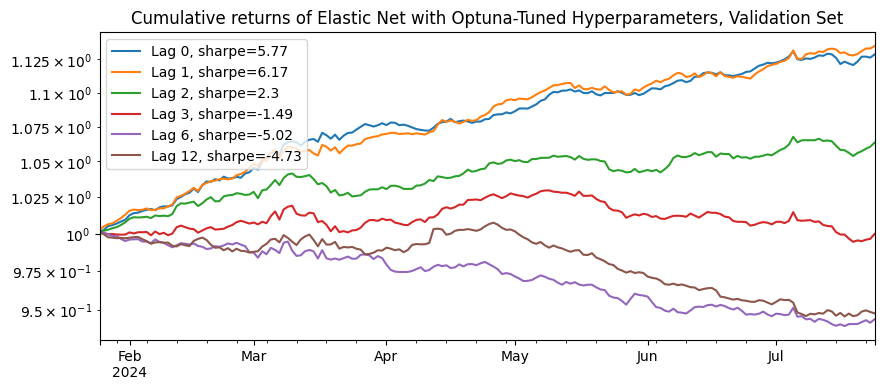

In [31]:
# ELASTIC NET WITH OPTUNA-TUNED HYPERPARAMETERS

print("="*60)
print("TRAINING ELASTIC NET WITH OPTUNA-TUNED HYPERPARAMETERS")
print("="*60)
print("\nOptuna-tuned hyperparameters:")
for k, v in hyperparameters_optuna.items():
    if k in ['alpha', 'l1_ratio', 'max_iter']:
        print(f"  {k}: {v}")
print("")

# Measure time
t1 = time.time()

# Train using one core per date with Optuna-tuned hyperparameters
predictions_optuna = []
importances_optuna = []

for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters_optuna,
    )
    predictions_optuna.append(pred)
    importances_optuna.append(imp)

# Reformat predictions
predictions_optuna = pd.concat(predictions_optuna, axis=1).T.groupby(level=1).sum().T
importance_df_optuna = pd.concat(importances_optuna, axis=1).fillna(0)
importance_mean_optuna = importance_df_optuna.mean(axis=1).sort_values(ascending=False)

print("\nTop 50 features (Optuna-Tuned Elastic Net) by average coefficient magnitude across folds:")
pd.set_option('display.max_colwidth', None)
display(importance_mean_optuna.head(50))
pd.reset_option('display.max_colwidth')

# Remove extra zeros added in the process
predictions_optuna = predictions_optuna.replace(0, np.nan)

# Remove empty and invalid dates
predictions_optuna = predictions_optuna.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Optuna-Tuned Elastic Net): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("OPTUNA-TUNED ELASTIC NET RESULTS - VALIDATION SET")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_optuna.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Elastic Net with Optuna-Tuned Hyperparameters, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)


#### Time decay weights 

The training uses 12 moneths of history with equal weights, I make the model care more about recent patterns by giving time decay sample weights, so we compute weight for each timestamp in each training fold, and pass these weights to model fit

In [32]:
def train_predict_period_timedecay(
    last_date_train_fold,
    returns,
    hyperparameters,
    lambda_decay=0.05,
):
    """
    Train Elastic Net with time-decayed sample weights.
    Recent data has higher weight than older data.

    :param last_date_train_fold: last training date for this fold
    :param returns: return data
    :param hyperparameters: Elastic Net hyperparameters dict
    :param lambda_decay: decay rate for time weights (0.01-0.1 typical)
    """

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days=30*12)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours=1)
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days=31)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")

        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold].shift(-1).stack()

        features_train_raw = features_normalized.reindex(label_fold.index)

        # mask: finite label AND all finite features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_raw).all(axis=1).values
        )

        label_fold = label_fold[mask]
        features_normalized_train_fold = features_train_raw[mask]
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # ===== TIME-DECAYED SAMPLE WEIGHTS =====
        # Recent data matters more than older data
        dates_train = label_fold.index.get_level_values(0)
        age = (last_date_train_fold - dates_train)
        age_days = age / np.timedelta64(1, "D")

        sample_weights = np.exp(-lambda_decay * age_days)
        sample_weights = np.asarray(sample_weights, dtype=float)

        print(
            f"   Time-decay (lambda={lambda_decay}): weights in "
            f"[{sample_weights.min():.4f}, {sample_weights.max():.4f}], "
            f"mean={sample_weights.mean():.4f}"
        )

        # Create model
        model = ElasticNet(**hyperparameters)

        # Fit model with sample weights
        model = model.fit(
            X=features_normalized_train_fold,
            y=label_fold,
            sample_weight=sample_weights,
        )

        # Feature importance (coefficients for Elastic Net)
        importance_gain = pd.Series(
            np.abs(model.coef_),
            index=features_normalized_train_fold.columns,
            name=str(last_date_train_fold)
        ).sort_values(ascending=False)

        # Predict on the validation set
        predictions = model.predict(features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return (pd.concat({str(last_date_train_fold) : predictions}, axis=1),
                importance_gain)


Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

   Time-decay (lambda=0.05): weights in [0.0369, 0.9979], mean=0.3007
Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0082, 0.9979], mean=0.2166
Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

   Time-decay (lambda=0.05): weights in [0.0017, 0.9979], mean=0.1679
Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0004, 0.9979], mean=0.1360
Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

   Time-decay (lambda=0.0

/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.421e+00, tolerance: 2.332e+00



Train a model from date 2022-12-05 00:00:00 to date 2023-11-30 00:00:00
Predict from date 2023-11-30 01:00:00 to date 2023-12-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0000, 0.9979], mean=0.0770


/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.736e+00, tolerance: 3.864e+00



Train a model from date 2023-01-05 00:00:00 to date 2023-12-31 00:00:00
Predict from date 2023-12-31 01:00:00 to date 2024-01-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0000, 0.9979], mean=0.0720
Train a model from date 2023-02-05 00:00:00 to date 2024-01-31 00:00:00
Predict from date 2024-01-31 01:00:00 to date 2024-03-02 00:00:00

   Time-decay (lambda=0.05): weights in [0.0000, 0.9979], mean=0.0684
Train a model from date 2023-03-06 00:00:00 to date 2024-02-29 00:00:00
Predict from date 2024-02-29 01:00:00 to date 2024-03-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0000, 0.9979], mean=0.0682
Train a model from date 2023-04-06 00:00:00 to date 2024-03-31 00:00:00
Predict from date 2024-03-31 01:00:00 to date 2024-05-01 00:00:00

   Time-decay (lambda=0.05): weights in [0.0000, 0.9979], mean=0.0679
Train a model from date 2023-05-06 00:00:00 to date 2024-04-30 00:00:00
Predict from date 2024-04-30 01:00:00 to date 2024-05-31 00:00:00

   Time-decay (lambda=0.0

funding_rate_std_6            0.0006
funding_rate_kurt_24          0.0005
volume_usd_shift_1            0.0004
funding_rate_level            0.0003
volume_usd_mean_120           0.0003
return_mean_6                 0.0002
close_shift_6                 0.0002
volume_usd_shift_3            0.0002
open_interest_value_shift_3   0.0002
feature_757966399344          0.0002
volume_usd_shift_6            0.0002
close_std_24                  0.0002
funding_rate_shift_24         0.0002
feature_349700183501          0.0002
volume_usd_std_24             0.0002
feature_597112414582          0.0002
nb_trades_std_6               0.0001
return_shift_1                0.0001
feature_034613324449          0.0001
open_interest_value_shift_1   0.0001
feature_360363963222          0.0001
nb_trades_shift_6             0.0001
feature_723195992091          0.0001
return_mean_24                0.0001
return_kurt_120               0.0001
feature_576016642244          0.0001
volume_usd_delta_6            0.0001
f


Total Training time (Time-Decay): 186.7 seconds

TIME-DECAY ELASTIC NET RESULTS


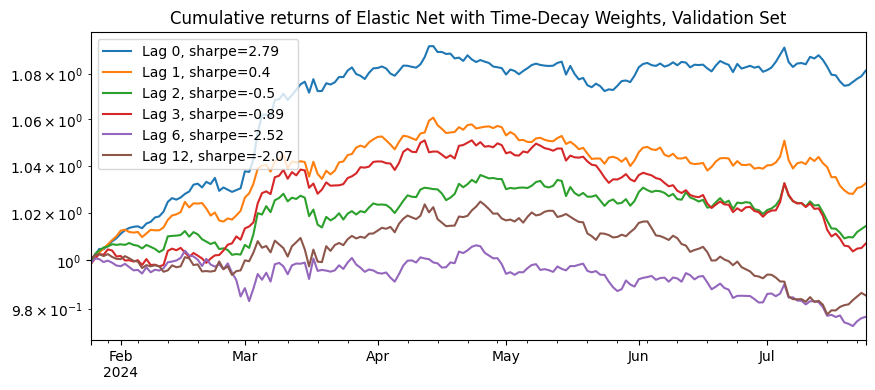

In [33]:
# ELASTIC NET WITH TIME-DECAYED WEIGHTS

# Measure time
t1 = time.time()

# Lambda for time decay (higher = faster decay)
lambda_decay = 0.05

# Train using one core per date, with time-decay weights
predictions_timedecay = []
importances_timedecay = []

for date in rebalancing_dates:
    pred, imp = train_predict_period_timedecay(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters,
        lambda_decay=lambda_decay,
    )
    predictions_timedecay.append(pred)
    importances_timedecay.append(imp)

# Reformat predictions
predictions_timedecay = pd.concat(predictions_timedecay, axis=1).T.groupby(level=1).sum().T
importance_df_timedecay = pd.concat(importances_timedecay, axis=1).fillna(0)
importance_mean_timedecay = importance_df_timedecay.mean(axis=1).sort_values(ascending=False)

print("\nTop 50 features (Time-Decay Elastic Net) by average coefficient magnitude across folds:")
pd.set_option('display.max_colwidth', None)
display(importance_mean_timedecay.head(50))
pd.reset_option('display.max_colwidth')

# Remove extra zeros added in the process
predictions_timedecay = predictions_timedecay.replace(0, np.nan)

# Remove empty and invalid dates
predictions_timedecay = predictions_timedecay.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Time-Decay): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("TIME-DECAY ELASTIC NET RESULTS")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_timedecay.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Elastic Net with Time-Decay Weights, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)


#### EN for multi-horizon


TRAINING ELASTIC NET FOR HORIZON: 1H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.063e+00, tolerance: 2.341e+00



Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30 01:00:00 to 2023-12-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e+01, tolerance: 3.865e+00



Train from 2023-01-05 00:00:00 to 2023-12-31 00:00:00
Predict from 2023-12-31 01:00:00 to 2024-01-31 00:00:00

Train from 2023-02-05 00:00:00 to 2024-01-31 00:00:00
Predict from 2024-01-31 01:00:00 to 2024-03-02 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e+01, tolerance: 5.697e+00



Train from 2023-03-06 00:00:00 to 2024-02-29 00:00:00
Predict from 2024-02-29 01:00:00 to 2024-03-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.440e+01, tolerance: 5.321e+00



Train from 2023-04-06 00:00:00 to 2024-03-31 00:00:00
Predict from 2024-03-31 01:00:00 to 2024-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.914e+01, tolerance: 4.895e+00



Train from 2023-05-06 00:00:00 to 2024-04-30 00:00:00
Predict from 2024-04-30 01:00:00 to 2024-05-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.501e+01, tolerance: 4.463e+00



Train from 2023-06-06 00:00:00 to 2024-05-31 00:00:00
Predict from 2024-05-31 01:00:00 to 2024-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.005e+01, tolerance: 3.999e+00



Train from 2023-07-06 00:00:00 to 2024-06-30 00:00:00
Predict from 2024-06-30 01:00:00 to 2024-07-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e+01, tolerance: 3.544e+00




Total training time for 1h: 344.0 seconds

RESULTS FOR HORIZON: 1H


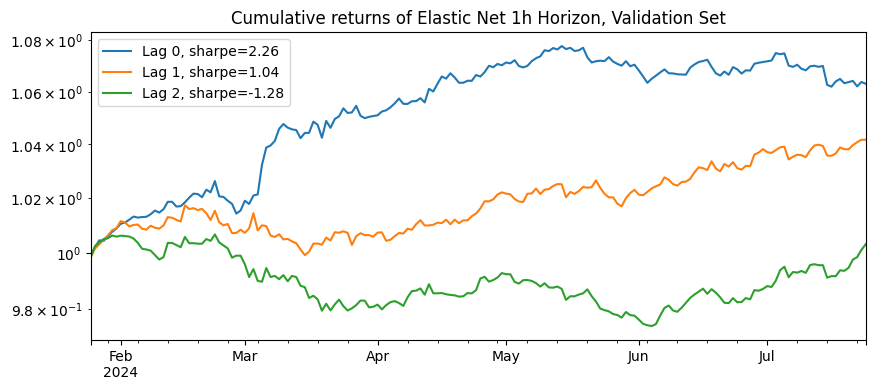


TRAINING ELASTIC NET FOR HORIZON: 3H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e+01, tolerance: 2.132e+00



Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.945e+01, tolerance: 6.292e+00



Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30 01:00:00 to 2023-12-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+02, tolerance: 1.107e+01



Train from 2023-01-05 00:00:00 to 2023-12-31 00:00:00
Predict from 2023-12-31 01:00:00 to 2024-01-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.722e+01, tolerance: 1.425e+01



Train from 2023-02-05 00:00:00 to 2024-01-31 00:00:00
Predict from 2024-01-31 01:00:00 to 2024-03-02 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e+02, tolerance: 1.738e+01



Train from 2023-03-06 00:00:00 to 2024-02-29 00:00:00
Predict from 2024-02-29 01:00:00 to 2024-03-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+02, tolerance: 1.623e+01



Train from 2023-04-06 00:00:00 to 2024-03-31 00:00:00
Predict from 2024-03-31 01:00:00 to 2024-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e+02, tolerance: 1.493e+01



Train from 2023-05-06 00:00:00 to 2024-04-30 00:00:00
Predict from 2024-04-30 01:00:00 to 2024-05-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e+02, tolerance: 1.361e+01



Train from 2023-06-06 00:00:00 to 2024-05-31 00:00:00
Predict from 2024-05-31 01:00:00 to 2024-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e+02, tolerance: 1.219e+01



Train from 2023-07-06 00:00:00 to 2024-06-30 00:00:00
Predict from 2024-06-30 01:00:00 to 2024-07-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e+02, tolerance: 1.081e+01




Total training time for 3h: 444.7 seconds

RESULTS FOR HORIZON: 3H


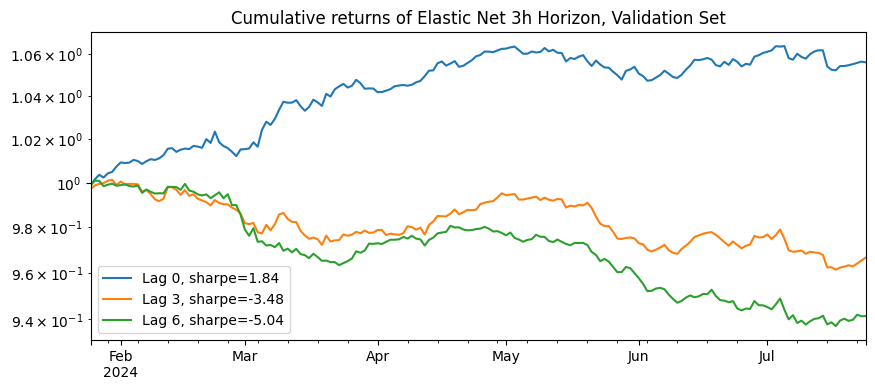


TRAINING ELASTIC NET FOR HORIZON: 6H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.509e+01, tolerance: 4.208e+00



Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+01, tolerance: 3.964e+00



Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e+01, tolerance: 8.280e+00



Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+01, tolerance: 6.605e+00



Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.969e+01, tolerance: 8.352e+00



Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e+02, tolerance: 1.208e+01



Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30 01:00:00 to 2023-12-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.354e+02, tolerance: 2.129e+01



Train from 2023-01-05 00:00:00 to 2023-12-31 00:00:00
Predict from 2023-12-31 01:00:00 to 2024-01-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.097e+02, tolerance: 2.766e+01



Train from 2023-02-05 00:00:00 to 2024-01-31 00:00:00
Predict from 2024-01-31 01:00:00 to 2024-03-02 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e+02, tolerance: 3.325e+01



Train from 2023-03-06 00:00:00 to 2024-02-29 00:00:00
Predict from 2024-02-29 01:00:00 to 2024-03-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e+02, tolerance: 3.106e+01



Train from 2023-04-06 00:00:00 to 2024-03-31 00:00:00
Predict from 2024-03-31 01:00:00 to 2024-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.090e+02, tolerance: 2.857e+01



Train from 2023-05-06 00:00:00 to 2024-04-30 00:00:00
Predict from 2024-04-30 01:00:00 to 2024-05-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.714e+02, tolerance: 2.605e+01



Train from 2023-06-06 00:00:00 to 2024-05-31 00:00:00
Predict from 2024-05-31 01:00:00 to 2024-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e+02, tolerance: 2.334e+01



Train from 2023-07-06 00:00:00 to 2024-06-30 00:00:00
Predict from 2024-06-30 01:00:00 to 2024-07-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e+02, tolerance: 2.068e+01




Total training time for 6h: 465.2 seconds

RESULTS FOR HORIZON: 6H


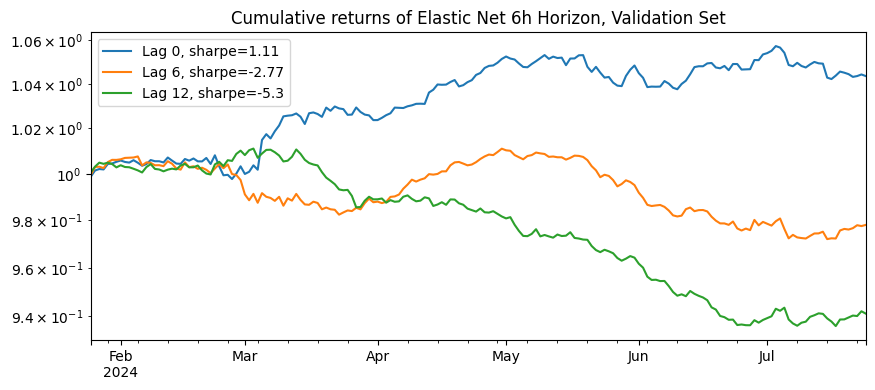


TRAINING ELASTIC NET FOR HORIZON: 12H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.216e+01, tolerance: 8.170e+00



Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.112e+01, tolerance: 7.601e+00



Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.658e+01, tolerance: 7.522e+00



Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e+02, tolerance: 1.284e+01



Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.788e+01, tolerance: 1.655e+01



Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+02, tolerance: 1.683e+01



Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.781e+02, tolerance: 2.287e+01



Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-30 01:00:00 to 2023-12-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.838e+02, tolerance: 3.975e+01



Train from 2023-01-05 00:00:00 to 2023-12-31 00:00:00
Predict from 2023-12-31 01:00:00 to 2024-01-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e+02, tolerance: 5.279e+01



Train from 2023-02-05 00:00:00 to 2024-01-31 00:00:00
Predict from 2024-01-31 01:00:00 to 2024-03-02 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.094e+02, tolerance: 6.514e+01



Train from 2023-03-06 00:00:00 to 2024-02-29 00:00:00
Predict from 2024-02-29 01:00:00 to 2024-03-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.949e+02, tolerance: 6.084e+01



Train from 2023-04-06 00:00:00 to 2024-03-31 00:00:00
Predict from 2024-03-31 01:00:00 to 2024-05-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.172e+02, tolerance: 5.596e+01



Train from 2023-05-06 00:00:00 to 2024-04-30 00:00:00
Predict from 2024-04-30 01:00:00 to 2024-05-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.906e+02, tolerance: 5.103e+01



Train from 2023-06-06 00:00:00 to 2024-05-31 00:00:00
Predict from 2024-05-31 01:00:00 to 2024-07-01 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e+02, tolerance: 4.572e+01



Train from 2023-07-06 00:00:00 to 2024-06-30 00:00:00
Predict from 2024-06-30 01:00:00 to 2024-07-31 00:00:00



/users/eleves-a/2024/an-binh.bui/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.851e+02, tolerance: 4.052e+01




Total training time for 12h: 487.5 seconds

RESULTS FOR HORIZON: 12H


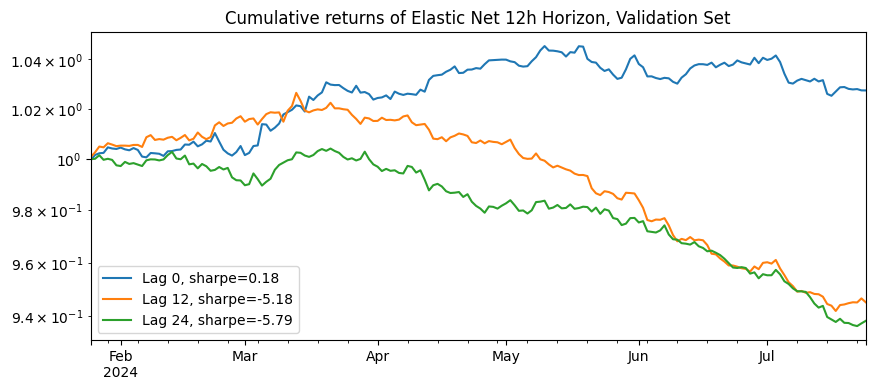

In [34]:
# Hyperparameters (keep the existing ones)
# Rebalancing dates
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME",
)[2:]

# Store predictions for each horizon
predictions_by_horizon = {}

# ===== LOOP OVER HORIZONS =====
for horizon_name, h in horizons.items():
    
    print(f"\n{'='*60}")
    print(f"TRAINING ELASTIC NET FOR HORIZON: {horizon_name.upper()}")
    print(f"{'='*60}\n")
    
    # Get label for this horizon
    label = labels_by_horizon[horizon_name]
    
    # Only keep common datetimes between label and features
    common_index = label.index.intersection(features_normalized.index)
    featuresnormalized_train = features_normalized.reindex(common_index)
    label_train = label.reindex(common_index)
    
    # Training loop (walk-forward cross-validation)
    t1 = time.time()
    
    predictions_list = []
    
    for date in rebalancing_dates:
        
        # Define fold dates
        start_date_train_fold = date - pd.Timedelta(days=30*12)
        start_date_validate_fold = date + pd.Timedelta(hours=1)
        last_date_validate_fold = date + pd.Timedelta(days=31)
        
        print(f"Train from {start_date_train_fold} to {date}")
        print(f"Predict from {start_date_validate_fold} to {last_date_validate_fold}\n")
        
        # Create label for this fold
        label_fold = label_train.loc[start_date_train_fold:date]
        
        # Features for train and validation
        features_train_fold = featuresnormalized_train.reindex(label_fold.index)
        features_validate_fold = features_normalized.loc[
            start_date_validate_fold:last_date_validate_fold
        ]
        
        # ===== TIME-DECAYED SAMPLE WEIGHTS =====
        # Recent data matters more than older data
        dates_train = label_fold.index.get_level_values(0)
        age = (date - dates_train)
        age_days = age / np.timedelta64(1, "D")
        
        lambda_decay = 0.05  # adjust: higher => faster decay
        sample_weights = np.exp(-lambda_decay * age_days)
        
        # ===== FILTER NON-FINITE VALUES =====
        # Remove NaN/inf from labels and features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_fold).all(axis=1).values
        )
        label_fold = label_fold[mask]
        features_train_fold = features_train_fold[mask]
        sample_weights = np.asarray(sample_weights[mask], dtype=np.float32)
        
        # Train Elastic Net
        with threadpool_limits(limits=1):
            model = ElasticNet(**hyperparameters)
            model.fit(
                X=features_train_fold,
                y=label_fold,
                sample_weight=sample_weights,
            )
            
            # Predict
            pred = model.predict(features_validate_fold)
            pred = pd.Series(pred, index=features_validate_fold.index).unstack()
            
            predictions_list.append(
                pd.concat({str(date): pred}, axis=1)
            )
    
    # Reformat predictions
    predictions = pd.concat(predictions_list, axis=1).T.groupby(level=1).sum().T
    predictions = predictions.replace(0, np.nan).dropna(axis=0, how='all')
    
    t2 = time.time()
    print(f"\nTotal training time for {horizon_name}: {t2-t1:.1f} seconds")
    
    # Store predictions
    predictions_by_horizon[horizon_name] = predictions
    
    # Analyze this horizon
    analyze_expected_returns(
        expected_returns=predictions.loc[start_date_validate:last_date_validate],
        returns=data["return"].loc[start_date_validate:last_date_validate],
        rfr_hourly=rfr_hourly,
        title=f"Elastic Net {horizon_name} Horizon, Validation Set",
        lags=[0, h, h*2],
        tc=tc,
    )


Then we ensemble across horizons


ELASTIC NET MULTI-HORIZON ENSEMBLE


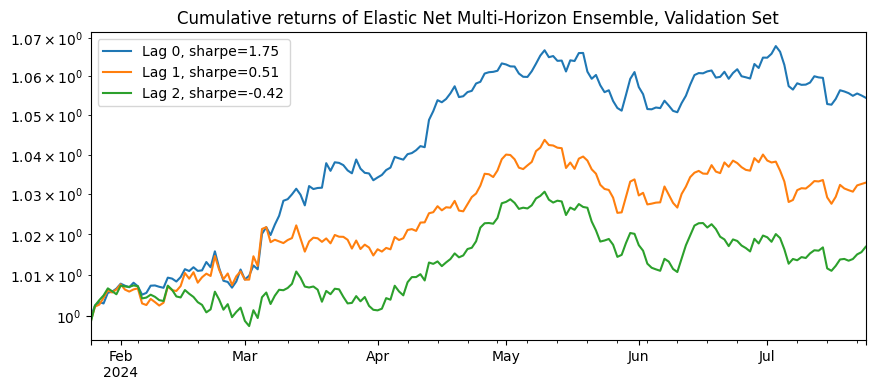

In [35]:
# Simple average across all 4 horizons
ensemble_predictions = (
    (predictions_by_horizon["1h"] + predictions_by_horizon["3h"] + 
     predictions_by_horizon["6h"] + predictions_by_horizon["12h"]) / 4
)

print("\n" + "="*60)
print("ELASTIC NET MULTI-HORIZON ENSEMBLE")
print("="*60)

analyze_expected_returns(
    expected_returns=ensemble_predictions.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title="Elastic Net Multi-Horizon Ensemble, Validation Set",
    lags=[0, 1, 2],
    tc=tc,
)
